In [1]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
#The Background Dataset
background = pd.read_csv('../datasets/training/background-giants.csv')

#The Background Dataset with Spectroscopic Redshifts
background_spec = pd.read_csv('../datasets/complete/back-giants.csv')

#Dataset with spectroscopic redshifts from NED
background = pd.merge(background, background_spec[['objID','Redshift']], on='objID')
background.head()

,objID,objID1,psfMag_u0,psfMag_g0,psfMag_r0,psfMag_i0,psfMag_z0,fiberMag_u0,fiberMag_g0,fiberMag_r0,...,fracDeV_z,ra,dec,dered_u,dered_g,dered_r,dered_i,dered_z,PhotoZ,Redshift
0,1237680311772250504,1237680311772250504,21.08928,19.37086,18.25864,17.81117,17.51476,21.25800,19.36015,18.24822,...,1.000000,16.783124,32.392580,20.13362,18.32410,17.19614,16.74197,16.40898,0.163294,0.153931
1,1237680315521237275,1237680315521237275,21.41094,19.66853,19.04671,18.49730,18.12082,21.32957,19.64395,18.69971,...,0.200284,16.739504,32.222824,18.94811,17.26758,16.39990,15.94577,15.60334,0.079898,0.114617
2,1237680311772250292,1237680311772250292,21.27979,19.46498,18.33810,17.92343,17.63418,21.25036,19.44884,18.34415,...,1.000000,16.624039,32.507760,20.15441,18.22609,17.11155,16.65807,16.33635,0.158405,0.153832
3,1237680311772381566,1237680311772381566,20.79575,18.89698,17.82768,17.38629,17.21747,20.79277,18.79881,17.79642,...,1.000000,17.110951,32.486381,19.56097,17.58059,16.57519,16.14223,15.82258,0.119085,0.111395
4,1237680316058107970,1237680316058107970,19.69155,17.76127,16.98154,16.55225,16.24577,19.77281,17.82529,16.89516,...,0.975430,16.737807,32.622441,18.35271,16.36183,15.47458,15.03607,14.70395,0.059261,0.066042


In [3]:
#Filtering out rows with invalid values
background = background.query('PhotoZ > -9999')

#Dataset for later ID merge
background_id = background[['objID', 'ra', 'dec']]

#Dropping the irrelevant features for training SVM model.
background = background.drop(['objID','objID1','ra','dec'], axis=1)
background.head()

,psfMag_u0,psfMag_g0,psfMag_r0,psfMag_i0,psfMag_z0,fiberMag_u0,fiberMag_g0,fiberMag_r0,fiberMag_i0,fiberMag_z0,...,fracDeV_r,fracDeV_i,fracDeV_z,dered_u,dered_g,dered_r,dered_i,dered_z,PhotoZ,Redshift
0,21.08928,19.37086,18.25864,17.81117,17.51476,21.25800,19.36015,18.24822,17.80149,17.45830,...,1.000000,1.000000,1.000000,20.13362,18.32410,17.19614,16.74197,16.40898,0.163294,0.153931
1,21.41094,19.66853,19.04671,18.49730,18.12082,21.32957,19.64395,18.69971,18.21872,17.81517,...,0.111197,0.102860,0.200284,18.94811,17.26758,16.39990,15.94577,15.60334,0.079898,0.114617
2,21.27979,19.46498,18.33810,17.92343,17.63418,21.25036,19.44884,18.34415,17.88955,17.55409,...,1.000000,1.000000,1.000000,20.15441,18.22609,17.11155,16.65807,16.33635,0.158405,0.153832
3,20.79575,18.89698,17.82768,17.38629,17.21747,20.79277,18.79881,17.79642,17.37555,17.02053,...,0.932025,0.997685,1.000000,19.56097,17.58059,16.57519,16.14223,15.82258,0.119085,0.111395
4,19.69155,17.76127,16.98154,16.55225,16.24577,19.77281,17.82529,16.89516,16.47335,16.13554,...,0.941605,0.954829,0.975430,18.35271,16.36183,15.47458,15.03607,14.70395,0.059261,0.066042


In [4]:
#The foreground dwarfs dataset
foreground = pd.read_csv('../datasets/training/foreground-dwarfs.csv')

#The foreground dwarfs dataset with spectroscopic redshifts
foreground_spec = pd.read_csv('../datasets/complete/dwarfs.csv')

#Dataset with spectroscopic redshifts from NED
foreground = pd.merge(foreground, foreground_spec[['objID','Redshift']], on='objID')

In [5]:
foreground_id = foreground[['objID', 'ra', 'dec']]

#Dropping the irrelevant features for training SVM model.
foreground = foreground.drop(['objID','objID1','ra','dec'], axis=1)
foreground.head()

,psfMag_u0,psfMag_g0,psfMag_r0,psfMag_i0,psfMag_z0,fiberMag_u0,fiberMag_g0,fiberMag_r0,fiberMag_i0,fiberMag_z0,...,fracDeV_r,fracDeV_i,fracDeV_z,dered_u,dered_g,dered_r,dered_i,dered_z,PhotoZ,Redshift
0,20.68459,20.32490,19.90491,19.65816,19.58863,20.93056,19.84648,19.39435,19.13173,18.93974,...,0.000000,0.000000,0.024766,17.14250,16.04856,15.63828,15.42416,15.29288,0.025635,0.016998
1,20.38590,18.79545,18.40734,18.01583,17.85035,20.31682,18.76537,18.05824,17.72758,17.45851,...,0.271305,0.262290,0.388589,18.42509,16.79932,16.11763,15.77143,15.49772,0.043808,0.014160
2,20.37486,19.15429,18.46381,18.16368,18.04567,20.36893,18.84602,18.14171,17.79829,17.57360,...,0.165721,0.215467,0.192362,18.37703,16.79943,16.09405,15.74896,15.51344,0.044954,0.020514
3,20.10566,18.50956,17.90357,17.60673,17.37036,20.09557,18.56411,17.81530,17.47781,17.24816,...,0.861712,0.876894,0.829082,17.90406,16.35933,15.61268,15.26653,15.02099,0.059635,0.018193
4,20.55464,18.93523,18.13289,17.79406,17.84563,20.42518,18.61701,17.89809,17.54489,17.28442,...,0.358013,0.392165,0.397820,18.33514,16.66942,15.94401,15.56867,15.34149,0.054202,0.018373


In [6]:
# In this case the label for background is 0 and foreground will be 1.
background['label'] = 0
foreground['label'] = 1

In [7]:
# Keep concatenated id when for later merge
galaxies_id = pd.concat([foreground_id,background_id])
galaxies_id.head()

,objID,ra,dec
0,1237680311772250464,16.765005,32.389555
1,1237680315521237319,16.792826,32.346872
2,1237680311772250198,16.685466,32.418586
3,1237680315521302864,16.966691,32.256108
4,1237680311772381486,17.066149,32.499011


In [8]:
# The foreground and background sets now have to be concated together and have the label column removed as a seperate 
# array to perform SVM.
galaxies = pd.concat([foreground,background])
galaxies.head()

,psfMag_u0,psfMag_g0,psfMag_r0,psfMag_i0,psfMag_z0,fiberMag_u0,fiberMag_g0,fiberMag_r0,fiberMag_i0,fiberMag_z0,...,fracDeV_i,fracDeV_z,dered_u,dered_g,dered_r,dered_i,dered_z,PhotoZ,Redshift,label
0,20.68459,20.32490,19.90491,19.65816,19.58863,20.93056,19.84648,19.39435,19.13173,18.93974,...,0.000000,0.024766,17.14250,16.04856,15.63828,15.42416,15.29288,0.025635,0.016998,1
1,20.38590,18.79545,18.40734,18.01583,17.85035,20.31682,18.76537,18.05824,17.72758,17.45851,...,0.262290,0.388589,18.42509,16.79932,16.11763,15.77143,15.49772,0.043808,0.014160,1
2,20.37486,19.15429,18.46381,18.16368,18.04567,20.36893,18.84602,18.14171,17.79829,17.57360,...,0.215467,0.192362,18.37703,16.79943,16.09405,15.74896,15.51344,0.044954,0.020514,1
3,20.10566,18.50956,17.90357,17.60673,17.37036,20.09557,18.56411,17.81530,17.47781,17.24816,...,0.876894,0.829082,17.90406,16.35933,15.61268,15.26653,15.02099,0.059635,0.018193,1
4,20.55464,18.93523,18.13289,17.79406,17.84563,20.42518,18.61701,17.89809,17.54489,17.28442,...,0.392165,0.397820,18.33514,16.66942,15.94401,15.56867,15.34149,0.054202,0.018373,1


In [9]:
background.shape

(160, 138)

In [10]:
foreground.shape

(413, 138)

### Finding Features with the Highest Correlation to Spectroscopic Redshift

In [11]:
# Trying to find the correlation between the features from SDSS and the spectroscopic redshift
c = galaxies.drop(['label'], axis=1).corr()['Redshift'].abs()
s = c.sort_values(kind='quicksort')
# Getting the 10 most correlated features to the spectroscopic redshift
s[-11:]

deVMag_r0       0.460143
expMag_u0       0.462322
deVMag_u0       0.475946
petroMag_g0     0.487731
cModelMag_g0    0.491257
dered_g         0.502360
expMag_g0       0.530510
deVMag_g0       0.537994
dered_u         0.554904
PhotoZ          0.707520
Redshift        1.000000
Name: Redshift, dtype: float64

In [12]:
features_corr_spec = s[-6:-1].to_frame()
features_corr_spec = features_corr_spec.index.tolist()
features_corr_spec

['dered_g', 'expMag_g0', 'deVMag_g0', 'dered_u', 'PhotoZ']

### Finding Features with the Highest Correlation to Classification Label

In [13]:
# Trying to find the correlation between the features from SDSS and classification label we added
c = galaxies.drop(['Redshift'], axis=1).corr()['label'].abs()
s = c.sort_values(kind='quicksort')
# Getting the 10 most correlated features to classifying label
s[-20:]

deVMag_z0       0.469878
deVRad_z        0.478380
deVMag_i0       0.498619
expMag_r0       0.501774
fracDeV_g       0.529997
deVMag_r0       0.537485
cModelMag_u0    0.548056
petroMag_g0     0.548267
cModelMag_g0    0.549462
dered_g         0.564940
fracDeV_r       0.568537
fracDeV_z       0.569263
fracDeV_i       0.574536
expMag_u0       0.584103
deVMag_u0       0.591555
expMag_g0       0.598086
deVMag_g0       0.617595
dered_u         0.629609
PhotoZ          0.747693
label           1.000000
Name: label, dtype: float64

In [14]:
features_corr_label = s[-11:-1].to_frame()
features_corr_label = features_corr_label.index.tolist()
features_corr_label

['dered_g',
 'fracDeV_r',
 'fracDeV_z',
 'fracDeV_i',
 'expMag_u0',
 'deVMag_u0',
 'expMag_g0',
 'deVMag_g0',
 'dered_u',
 'PhotoZ']

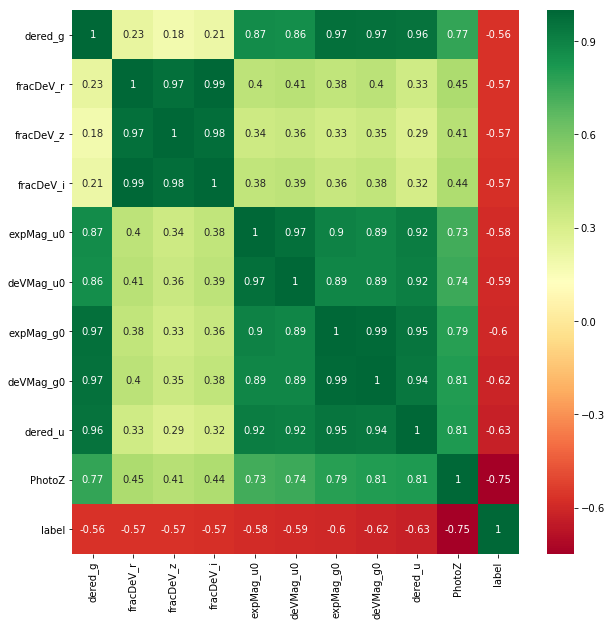

In [27]:
# Correlation Matrix with Heatmap
corrmat = galaxies[s[-11:].index.tolist()].corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
g=sns.heatmap(galaxies[top_corr_features].corr(),annot=True,cmap="RdYlGn")

### Training Model on Selected Features

In [15]:
# Parameter tuning using GridSearchCV
def svc_param_selection(X, y):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1, 10]
    nfolds = 5
    param_grid = {'C': Cs, 'gamma': gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    return grid_search.best_params_

In [16]:
X = galaxies[features_corr_label]
y = galaxies['label']

In [17]:
# Cross validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape, y_train.shape

((458, 10), (458,))

In [18]:
X_test.shape, y_test.shape

((115, 10), (115,))

In [19]:
params = svc_param_selection(X, y)
params

{'C': 10, 'gamma': 1}

In [20]:
clf = svm.SVC(C=params['C'], gamma=params['gamma'])
clf.fit(X_train, y_train)
scores = cross_val_score(clf, X_test, y_test, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.87 (+/- 0.10)


In [21]:
# Using polynomial kernel of different degrees
polyModel_deg1 = svm.SVC(C=params['C'], gamma=params['gamma'], kernel='poly', degree=1)
polyModel_deg1.fit(X_train, y_train)
scores = cross_val_score(polyModel_deg1, X_test, y_test, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.95 (+/- 0.09)


In [22]:
polyModel_deg2 = svm.SVC(C=params['C'], gamma=params['gamma'], kernel='poly', degree=2)
polyModel_deg2.fit(X_train, y_train)
scores = cross_val_score(polyModel_deg2, X_test, y_test, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.89 (+/- 0.14)


In [23]:
polyModel_deg3 = svm.SVC(C=params['C'], gamma=params['gamma'], kernel='poly', degree=3)
polyModel_deg3.fit(X_train, y_train)
scores = cross_val_score(polyModel_deg3, X_test, y_test, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.88 (+/- 0.20)
